# Investigación y preparación de datos: 

---

## 1) `torch.nn.RNN` (PyTorch)

**i. Input esperado**

- Forma por defecto: `x.shape = (seq_len, batch, input_size)`.
- Si `batch_first=True`: `x.shape = (batch, seq_len, input_size)`.
- Estado oculto inicial (opcional) `h0.shape = (num_layers * num_directions, batch, hidden_size)`.
- Puedes pasar también un `PackedSequence` (via `torch.nn.utils.rnn.pack_padded_sequence`) para manejar longitudes variables.

**ii. Output que devuelve**

- `output`: todas las salidas por *time-step* de la **última** capa.
  - Por defecto: `output.shape = (seq_len, batch, num_directions * hidden_size)`.
  - Con `batch_first=True`: `output.shape = (batch, seq_len, num_directions * hidden_size)`.
- `hn`: estado oculto final **por capa y dirección**  
  `hn.shape = (num_layers * num_directions, batch, hidden_size)`.

> **Nota**  
> - `num_directions = 2` si `bidirectional=True`, en otro caso `= 1`.  
> - Si usas `PackedSequence`, `output` será `PackedSequence` y `hn` conserva su forma estándar.

**iii. Parámetros de configuración importantes**

- `input_size`: dimensión de la característica de entrada por *time-step*.
- `hidden_size`: tamaño del estado oculto por dirección.
- `num_layers` (def. `1`): apila múltiples capas RNN.
- `nonlinearity` (solo `RNN`): `'tanh'` (defecto) o `'relu'`.
- `bias` (def. `True`): incluye sesgos en las proyecciones.
- `batch_first` (def. `False`): si `True`, el batch va primero.
- `dropout` (def. `0.0`): *dropout* aplicado entre capas (si `num_layers > 1`).
- `bidirectional` (def. `False`): activa una RNN bidireccional (adelante y atrás).

---

## 2) Dataset **Sunspots**

**i. ¿Qué mide?**  
Cuenta (o índice) de manchas solares observadas en la superficie del Sol. Es un *proxy* de la actividad solar.

**ii. ¿Cuál es el rango temporal de los datos?**  
Depende de la fuente/versionado:
- **Serie anual** clásica (incluida en `statsmodels.datasets.sunspots`): ~**1700–2008** (anual).
- **Serie mensual** del SILSO/NOAA: **1749–presente** (mensual; suele actualizarse periódicamente).  
Para ejercicios reproducibles offline, la versión anual de `statsmodels` es práctica.

**iii. ¿Por qué es útil para predecir series temporales?**  
- Presenta **ciclos cuasi-periódicos** (~11 años) → patrón útil para modelos secuenciales.  
- Incluye **tendencias/variaciones** de amplitud y ruidos realistas → buen *benchmark* para RNN/LSTM/Transformers.  
- Es **univariada** y de **baja dimensionalidad**, ideal para demostrar *pipelines* de predicción.




,sunspots
date,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


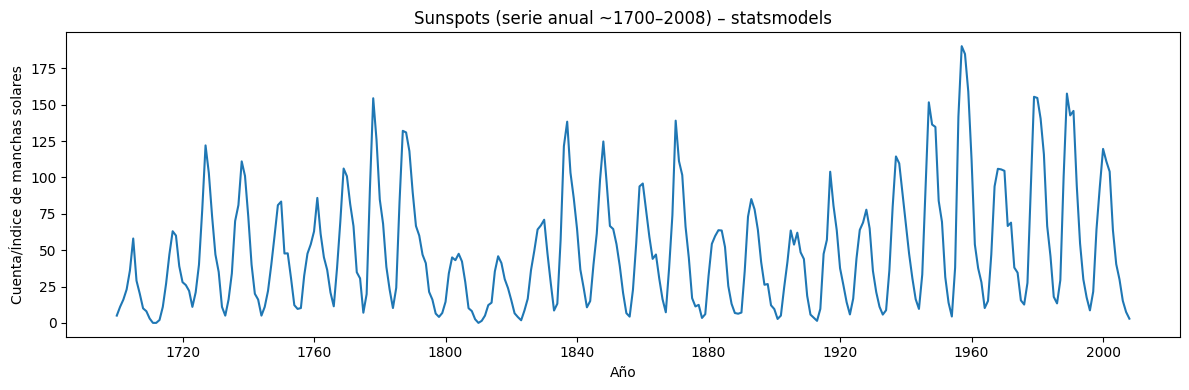

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import sunspots as sm_sunspots

# Cargar a DataFrame
data = sm_sunspots.load_pandas().data  # columnas típicas: YEAR, SUNACTIVITY
df = pd.DataFrame({
    "date": pd.to_datetime(data["YEAR"], format="%Y"),
    "sunspots": data["SUNACTIVITY"].astype(float)
}).set_index("date")

display(df.head())  # primeras filas

# Visualización de la serie completa (anual)
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["sunspots"])
plt.title("Sunspots (serie anual ~1700–2008) – statsmodels")
plt.xlabel("Año")
plt.ylabel("Cuenta/Índice de manchas solares")
plt.tight_layout()
plt.show()

,sunspots,sunspots_norm
date,,
1700-01-01,5.0,-0.947424
1701-01-01,11.0,-0.884332
1702-01-01,16.0,-0.831756
1703-01-01,23.0,-0.758149
1704-01-01,36.0,-0.621451


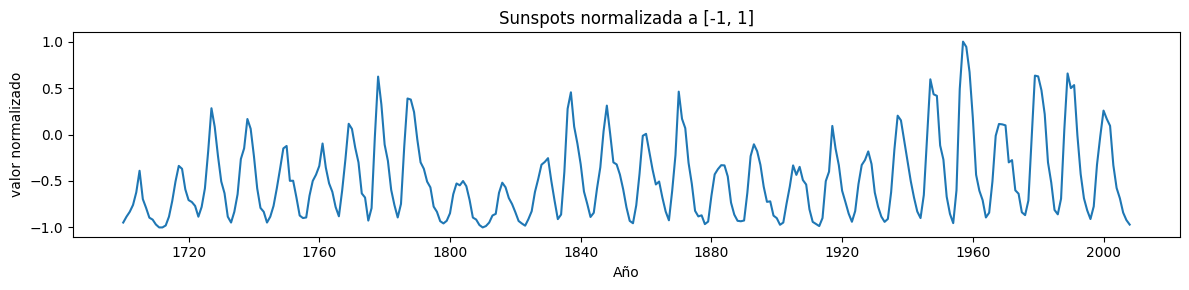

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

df["sunspots_norm"] = scaler.fit_transform(df[["sunspots"]])  # ajusta y transforma columna
display(df.head())

# Visualizar normalizada
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.plot(df.index, df["sunspots_norm"])
plt.title("Sunspots normalizada a [-1, 1]")
plt.xlabel("Año")
plt.ylabel("valor normalizado")
plt.tight_layout()
plt.show()


In [4]:

# !pip install torch statsmodels pandas matplotlib scikit-learn -q

import math, time, random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.datasets import sunspots as sm_sunspots

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Cargar serie anual de Sunspots
raw = sm_sunspots.load_pandas().data  # columnas: YEAR, SUNACTIVITY
df = pd.DataFrame({
    "date": pd.to_datetime(raw["YEAR"], format="%Y"),
    "sunspots": raw["SUNACTIVITY"].astype(float)
}).set_index("date").sort_index()

# 2) Normalizar a [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df["sunspots_norm"] = scaler.fit_transform(df[["sunspots"]])

df.head()


,sunspots,sunspots_norm
date,,
1700-01-01,5.0,-0.947424
1701-01-01,11.0,-0.884332
1702-01-01,16.0,-0.831756
1703-01-01,23.0,-0.758149
1704-01-01,36.0,-0.621451


In [5]:
def make_windows(series: pd.Series, window: int, horizon: int = 1):
    """
    Convierte una serie (pd.Series) en tensores (X, y) para aprendizaje supervisado:
      - X: (N, window, 1)
      - y: (N,)  si horizon=1  | (N, horizon) si horizon>1
    """
    vals = series.to_numpy(dtype="float32")
    X, y = [], []
    for i in range(len(vals) - window - horizon + 1):
        X.append(vals[i : i + window])
        y.append(vals[i + window : i + window + horizon])
    X = torch.tensor(np.array(X)).unsqueeze(-1)  # (N, window, 1)
    y = torch.tensor(np.array(y))
    if horizon == 1:
        y = y.squeeze(-1)  # (N,)
    return X, y

def temporal_train_test_split(X, y, train_ratio=0.8):
    n = X.shape[0]
    n_train = int(n * train_ratio)
    X_tr, y_tr = X[:n_train], y[:n_train]
    X_te, y_te = X[n_train:], y[n_train:]
    return X_tr, y_tr, X_te, y_te


In [6]:
class RNNForecaster(nn.Module):
    def __init__(self,
                 input_size=1,
                 hidden_size=64,
                 num_layers=1,
                 bidirectional=False,
                 nonlinearity='tanh',
                 dropout=0.0):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,   # 'tanh' (defecto) o 'relu'
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, 1)  # salida escalar

    def forward(self, x, h0=None):
        """
        x: (batch, seq_len, input_size)  porque batch_first=True
        return: (batch,)  predicción para el siguiente paso
        """
        out, hn = self.rnn(x, h0)               # out: (B, T, H[*2])
        last_timestep = out[:, -1, :]           # (B, H[*2])
        yhat = self.fc(last_timestep)           # (B, 1)
        return yhat.squeeze(-1)                 # (B,)


In [7]:
def train_one_model(window_size=10,
                    hidden_size=64,
                    num_layers=1,
                    lr=1e-3,
                    batch_size=32,
                    epochs=200,
                    clip_grad=1.0,
                    verbose_every=20):

    # --- 1) Ventanas y split ---
    X, y = make_windows(df["sunspots_norm"], window=window_size, horizon=1)
    X_tr, y_tr, X_te, y_te = temporal_train_test_split(X, y, train_ratio=0.8)

    train_ds = TensorDataset(X_tr, y_tr)
    test_ds  = TensorDataset(X_te, y_te)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # --- 2) Modelo ---
    model = RNNForecaster(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=False,
        nonlinearity='tanh',
        dropout=0.0
    ).to(device)

    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # --- 3) Entrenamiento ---
    history = {
        "train_loss": [],
        "val_loss": [],
        "grad_norm": [],
        "epoch_time_sec": []
    }

    best_val = math.inf
    best_state = None
    start_total = time.time()

    for epoch in range(1, epochs + 1):
        t0 = time.time()
        model.train()
        running = 0.0
        gn_epoch_vals = []

        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            optim.zero_grad()
            yhat = model(xb)              # (B,)
            loss = criterion(yhat, yb)
            loss.backward()

            # Gradiente global L2 para monitorear estabilidad
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.detach().data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gn_epoch_vals.append(total_norm)

            # Clipping (mitiga exploding gradients)
            if clip_grad is not None and clip_grad > 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

            optim.step()
            running += loss.item() * xb.size(0)

        train_loss = running / len(train_ds)

        # --- Validación ---
        model.eval()
        with torch.no_grad():
            val_running = 0.0
            for xb, yb in test_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                yhat = model(xb)
                val_running += criterion(yhat, yb).item() * xb.size(0)
            val_loss = val_running / len(test_ds)

        epoch_time = time.time() - t0

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["grad_norm"].append(float(np.mean(gn_epoch_vals)))
        history["epoch_time_sec"].append(epoch_time)

        # Guardar mejor estado por val_loss
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if verbose_every and (epoch % verbose_every == 0 or epoch == 1):
            print(f"[win={window_size}] Epoch {epoch:3d} | "
                  f"train={train_loss:.6f} val={val_loss:.6f} | "
                  f"grad_norm≈{np.mean(gn_epoch_vals):.4f} | "
                  f"time={epoch_time:.2f}s")

    total_time = time.time() - start_total

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    summary = {
        "window": window_size,
        "best_val_mse": best_val,
        "epochs": epochs,
        "mean_grad_norm": float(np.mean(history["grad_norm"])),
        "max_grad_norm": float(np.max(history["grad_norm"])),
        "total_train_time_sec": total_time
    }
    return model, history, summary

# === Entrenar con ventana inicial de 10 ===
model_10, hist_10, sum_10 = train_one_model(window_size=10, hidden_size=64, epochs=150, verbose_every=25)
sum_10


[win=10] Epoch   1 | train=0.329628 val=0.285123 | grad_norm≈1.6448 | time=0.10s
[win=10] Epoch  25 | train=0.033567 val=0.053281 | grad_norm≈0.2054 | time=0.04s
[win=10] Epoch  50 | train=0.023607 val=0.037336 | grad_norm≈0.2013 | time=0.04s
[win=10] Epoch  75 | train=0.020211 val=0.039218 | grad_norm≈0.1321 | time=0.04s
[win=10] Epoch 100 | train=0.019445 val=0.040029 | grad_norm≈0.1965 | time=0.04s
[win=10] Epoch 125 | train=0.017901 val=0.035082 | grad_norm≈0.2828 | time=0.05s
[win=10] Epoch 150 | train=0.015675 val=0.033920 | grad_norm≈0.1798 | time=0.04s


{'window': 10,
 'best_val_mse': 0.03211988769471645,
 'epochs': 150,
 'mean_grad_norm': 0.20929538868421266,
 'max_grad_norm': 1.6447607287616945,
 'total_train_time_sec': 5.9442808628082275}

## **Experimentación con diferentes ventanas**

In [8]:
windows = [5, 20, 100]
summaries = [sum_10]  # ya incluye la de 10 pasos

trained = {10: (model_10, hist_10)}

for w in windows:
    m, h, s = train_one_model(window_size=w, hidden_size=64, epochs=150, verbose_every=25)
    trained[w] = (m, h)
    summaries.append(s)

pd.DataFrame(summaries).sort_values("window").reset_index(drop=True)


[win=5] Epoch   1 | train=0.383343 val=0.257784 | grad_norm≈2.0417 | time=0.05s
[win=5] Epoch  25 | train=0.035627 val=0.076604 | grad_norm≈0.1535 | time=0.03s
[win=5] Epoch  50 | train=0.025566 val=0.056680 | grad_norm≈0.1283 | time=0.05s
[win=5] Epoch  75 | train=0.023566 val=0.050947 | grad_norm≈0.1467 | time=0.04s
[win=5] Epoch 100 | train=0.022752 val=0.049276 | grad_norm≈0.1898 | time=0.04s
[win=5] Epoch 125 | train=0.021521 val=0.052371 | grad_norm≈0.2235 | time=0.05s
[win=5] Epoch 150 | train=0.020291 val=0.043478 | grad_norm≈0.1940 | time=0.03s
[win=20] Epoch   1 | train=0.173912 val=0.347135 | grad_norm≈0.8774 | time=0.06s
[win=20] Epoch  25 | train=0.029696 val=0.052389 | grad_norm≈0.1888 | time=0.05s
[win=20] Epoch  50 | train=0.022318 val=0.039711 | grad_norm≈0.1531 | time=0.16s
[win=20] Epoch  75 | train=0.022216 val=0.041410 | grad_norm≈0.1475 | time=0.07s
[win=20] Epoch 100 | train=0.020586 val=0.041340 | grad_norm≈0.1766 | time=0.08s
[win=20] Epoch 125 | train=0.019326

,window,best_val_mse,epochs,mean_grad_norm,max_grad_norm,total_train_time_sec
0,5,0.042973,150,0.192812,2.041690,5.756911
1,10,0.032120,150,0.209295,1.644761,5.944281
2,20,0.036298,150,0.198183,0.877352,11.313121
3,100,0.020797,150,0.266840,1.941591,16.400409


## **Resultados**

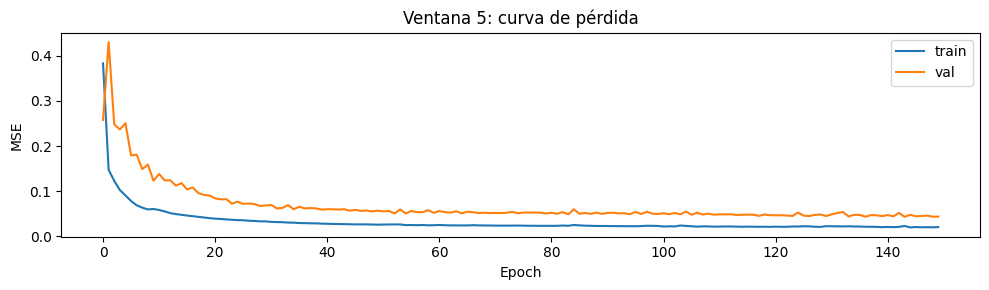

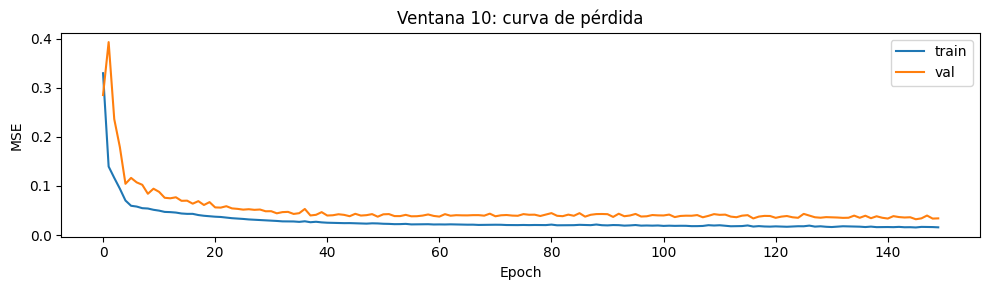

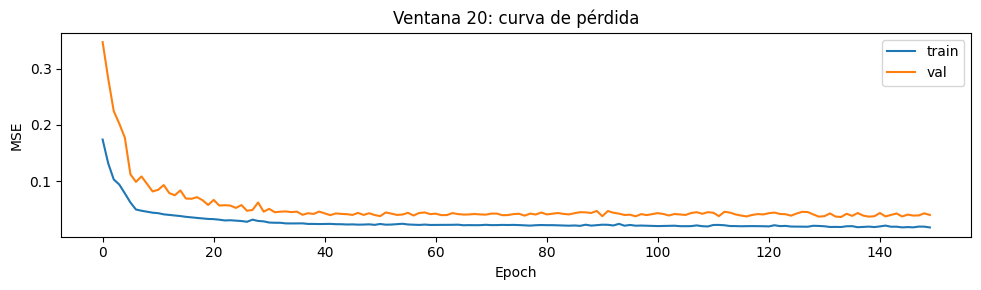

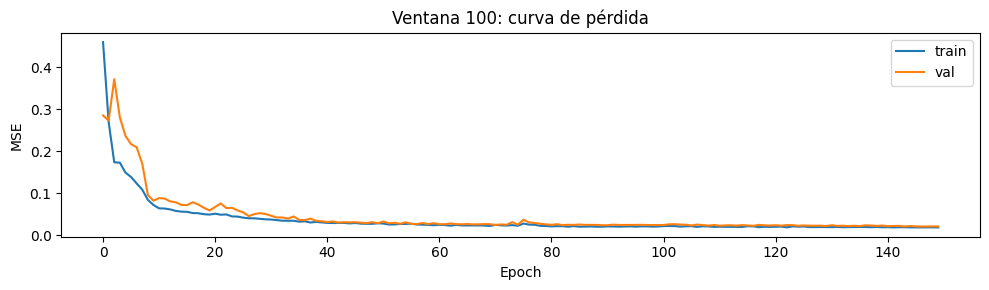

In [9]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    plt.figure(figsize=(10,3))
    plt.plot(hist["train_loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.tight_layout()
    plt.show()

for w in sorted(trained.keys()):
    _, h = trained[w]
    plot_history(h, title=f"Ventana {w}: curva de pérdida")
